<a href="https://colab.research.google.com/github/rohit9650/ML/blob/master/kaggle/Elo%20Merchant/first.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
files.upload()

In [2]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 62 Feb  9 17:30 kaggle.json


In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# downloading Data
!kaggle competitions download -c elo-merchant-category-recommendation

historical_transactions.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
merchants.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
new_merchant_transactions.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Data_Dictionary.xlsx: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
# un-zipping


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import lightgbm as lgb
from sklearn.model_selection import KFold
import time
import sys
import datetime
import seaborn as sns

In [0]:
def reduce_mem_usage(df, verbose=True):
  
  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  start_mem = df.memory_usage().sum() /1024**2
  
  for col in df.columns:
    col_type = df[col].dtypes
    if col_type in numerics:
      c_min = df[col].min()
      c_max = df[col].max()
      if str(col_type)[:3] == 'int':
        if (c_min > np.iinfo(np.int8).min and
            c_max < np.iinfo(np.int8).max):
          df[col] = df[col].astype(np.int8)
        elif (c_min > np.iinfo(np.int16).min and
              c_max < np.iinfo(np.int16).max):
          df[col] = df[col].astype(np.int16)
        elif (c_min > np.iinfo(np.int32).min and
              c_max < np.iinfo(np.int32).max):
          df[col] = df[col].astype(np.int32)
        elif (c_min > np.iinfo(np.int64).min and
              c_max < np.iinfo(np.int64).max):
          df[col] = df[col].astype(np.int64)
      else:
        if (c_min > np.finfo(np.float16).min and
            c_max < np.finfo(np.float16).max):
          df[col] = df[col].astype(np.float16)
        elif (c_min > np.finfo(np.float32).min and
              c_max < np.finfo(np.float32).max):
          df[col] = df[col].astype(np.float32)
        else:
          df[col] = df[col].astype(np.float64)
          
  end_mem = df.memory_usage().sum() / 1024**2
  
  if verbose:
    print('Mem. usage reduced to {5.2f} Mb ({:.1f}% reduction)'.format(
        end_mem,
        100 * (start_mem - end_mem) / start_mem))
 
  return df

In [8]:
#unzip
!unzip '/content/new_merchant_transactions.csv.zip'

# New Transaction
new_transactions = pd.read_csv('/content/new_merchant_transactions.csv')
new_transactions['authorized_flag'] = new_transactions[
    'authorized_flag'].map({'Y':1, 'N':0})
new_transactions[:5]

Archive:  /content/new_merchant_transactions.csv.zip
replace new_merchant_transactions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,1,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,1,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,1,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,1,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [9]:
def aggregate_new_transactions(new_trans):
  agg_func = {
      'authorized_flag' : ['sum', 'mean'],
      'merchant_id' : ['nunique'],
      'city_id' : ['nunique'],
      'purchase_amount' : ['sum', 'median', 'max', 'min', 'std'],
      'installments' : ['sum', 'median', 'max', 'min', 'std'],
      'month_lag' : ['min', 'max']
  }
  agg_new_trans = new_trans.groupby(['card_id']).agg(agg_func)
  agg_new_trans.columns = ['new' + '-'.join(col).strip() 
                           for col in agg_new_trans.columns.values]
  agg_new_trans.reset_index(inplace=True)
  
  df = (new_trans.groupby('card_id').
        size().
        reset_index(name='new_transactions_count'))
  
  agg_new_trans = pd.merge(df, agg_new_trans, on='card_id', how='left')
  
  return agg_new_trans

new_trans = aggregate_new_transactions(new_transactions)
new_trans[:10]

,card_id,new_transactions_count,newauthorized_flag-sum,newauthorized_flag-mean,newmerchant_id-nunique,newcity_id-nunique,newpurchase_amount-sum,newpurchase_amount-median,newpurchase_amount-max,newpurchase_amount-min,newpurchase_amount-std,newinstallments-sum,newinstallments-median,newinstallments-max,newinstallments-min,newinstallments-std,newmonth_lag-min,newmonth_lag-max
0,C_ID_00007093c1,2,2,1,2,2,-1.328524,-0.664262,-0.656749,-0.671775,0.010625,2,1.0,1,1,0.000000,2,2
1,C_ID_0001238066,26,26,1,25,8,-14.850055,-0.649235,-0.078318,-0.740897,0.173436,42,1.0,10,-1,2.079941,1,2
2,C_ID_0001506ef0,2,2,1,1,1,-1.447354,-0.723677,-0.715352,-0.732001,0.011773,0,0.0,0,0,0.000000,1,1
3,C_ID_0001793786,31,31,1,31,7,-0.229620,-0.372748,3.129932,-0.737892,0.947223,0,0.0,0,0,0.000000,1,2
4,C_ID_000183fdda,11,11,1,11,2,-6.590778,-0.665765,-0.107680,-0.732332,0.182877,16,1.0,4,-1,1.293340,1,2
5,C_ID_0002709b5a,3,3,1,3,3,-2.018827,-0.680791,-0.611669,-0.726367,0.057750,1,1.0,1,-1,1.154701,1,2
6,C_ID_000298032a,1,1,1,1,1,-0.641872,-0.641872,-0.641872,-0.641872,NaN,0,0.0,0,0,NaN,2,2
7,C_ID_0002ba3c2e,3,3,1,3,1,-2.071059,-0.697561,-0.667883,-0.705615,0.019872,0,0.0,0,0,0.000000,1,2
8,C_ID_0002c7c2c1,6,6,1,6,3,-3.929448,-0.671324,-0.497768,-0.731881,0.083328,0,0.0,0,0,0.000000,1,2
9,C_ID_00032df08f,8,8,1,7,1,-2.791535,-0.478579,0.449203,-0.640520,0.366423,8,1.0,1,1,0.000000,2,2


In [10]:
#unzip
!unzip '/content/historical_transactions.csv.zip'

# Historical Transaction
historical_transactions = pd.read_csv(
    '/content/historical_transactions.csv')
historical_transactions['authorized_flag'] = historical_transactions[
    'authorized_flag'].map({'Y':1, 'N':0})
historical_transactions[:5]

Archive:  /content/historical_transactions.csv.zip
replace historical_transactions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,1,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,1,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,1,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,1,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [11]:
def aggregate_historical_transactions(history):
  agg_func = {
      'authorized_flag' : ['sum', 'mean'],
      'merchant_id' : ['nunique'],
      'city_id' : ['nunique'],
      'purchase_amount' : ['sum', 'median', 'max', 'min', 'std'],
      'installments' : ['sum', 'median', 'max', 'min', 'std'],
      'month_lag' : ['min', 'max']
  }
  agg_history = history.groupby(['card_id']).agg(agg_func)
  agg_history.columns = ['new' + '-'.join(col).strip() 
                           for col in agg_history.columns.values]
  agg_history.reset_index(inplace=True)
  
  df = (history.groupby('card_id').
        size().
        reset_index(name='hist_transactions_count'))
  
  agg_history = pd.merge(df, agg_history, on='card_id', how='left')
  
  return agg_history

history = aggregate_historical_transactions(historical_transactions)
history[:10]

,card_id,hist_transactions_count,newauthorized_flag-sum,newauthorized_flag-mean,newmerchant_id-nunique,newcity_id-nunique,newpurchase_amount-sum,newpurchase_amount-median,newpurchase_amount-max,newpurchase_amount-min,newpurchase_amount-std,newinstallments-sum,newinstallments-median,newinstallments-max,newinstallments-min,newinstallments-std,newmonth_lag-min,newmonth_lag-max
0,C_ID_00007093c1,149,114,0.765101,29,4,-76.845041,-0.587627,1.507069,-0.728876,0.298141,192,1.0,6,1,0.764900,-12,0
1,C_ID_0001238066,123,120,0.975610,65,18,-72.447201,-0.648184,0.768095,-0.734887,0.190235,198,1.0,10,-1,1.485637,-5,0
2,C_ID_0001506ef0,66,62,0.939394,28,3,-34.601879,-0.703707,1.493545,-0.740491,0.472284,1,0.0,1,0,0.123091,-13,0
3,C_ID_0001793786,216,189,0.875000,119,10,-36.786013,-0.487911,4.554145,-0.745405,0.836046,5,0.0,1,0,0.150723,-9,0
4,C_ID_000183fdda,144,137,0.951389,73,9,-68.837938,-0.661294,2.764788,-0.737892,0.524948,264,1.0,10,-1,2.118846,-6,0
5,C_ID_00024e244b,70,53,0.757143,19,3,-41.552753,-0.709342,2.258395,-0.740897,0.416742,5,0.0,1,0,0.259399,-13,0
6,C_ID_0002709b5a,73,67,0.917808,35,4,-47.659542,-0.677275,-0.336684,-0.727388,0.078777,129,1.0,12,-1,2.182764,-13,0
7,C_ID_00027503e2,42,24,0.571429,12,2,-31.123047,-0.741213,-0.734135,-0.745871,0.003334,0,0.0,0,0,0.000000,-8,0
8,C_ID_000298032a,30,28,0.933333,20,5,-15.992416,-0.642436,2.577843,-0.719529,0.589542,0,0.0,0,0,0.000000,-11,0
9,C_ID_0002ba3c2e,70,55,0.785714,35,3,-44.342996,-0.682113,-0.097011,-0.742400,0.129401,0,0.0,0,0,0.000000,-9,0


In [20]:
#unzip
!unzip '/content/train.csv.zip'
!unzip '/content/test.csv.zip'

#adding new features and making target

def read_data(input_file):
  df = pd.read_csv(input_file)
  df['first_active_month'] = pd.to_datetime(df['first_active_month'])
  df['year'] = df['first_active_month'].dt.year
  df['month'] = df['first_active_month'].dt.month
  df['elapsed_time'] = (datetime.date(2018, 2, 1) - df[
      'first_active_month'].dt.date).dt.days
  
  return df

train = read_data('/content/train.csv')
test = read_data('/content/test.csv')

target = train['target']
del train['target']

Archive:  /content/train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  /content/test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [21]:
# merging the data
train = pd.merge(train, history, on='card_id', how='left')
train = pd.merge(train, new_trans, on='card_id', how='left')

test = pd.merge(test, history, on='card_id', how='left')
test = pd.merge(test, new_trans, on='card_id', how='left')

print(train.shape)
print(test.shape)

(201917, 42)
(123623, 42)


In [23]:
# feature preparation

use_cols = [col for col in train.columns if col not in 
            ['card_id', 'first_active_month']]

train = train[use_cols]
test = test[use_cols]

features = list(train[use_cols].columns)
categorical_feats = [col for col in features if 'feature_' in col]

for col in categorical_feats:
  print(col, 'have',train[col].value_counts().shape[0], 'categories')

feature_1 have 5 categories
feature_2 have 3 categories
feature_3 have 2 categories


In [25]:
from sklearn.preprocessing import LabelEncoder

for col in categorical_feats:
  print(col)
  lbl = LabelEncoder()
  lbl.fit(list(train[col].values.astype('str'))+ 
          list(test[col].values.astype('str')))
  train[col] = lbl.transform(list(train[col].values.astype('str')))
  test[col] = lbl.transform(list(test[col].values.astype('str')))

feature_1
feature_2
feature_3


In [0]:
df_all = pd.concat([train, test])
df_all = pd.get_dummies(df_all, columns=categorical_feats)

len_train = train.shape[0]

train = df_all[:len_train]
test = df_all[len_train:]

In [32]:
# LGB
from sklearn.model_selection import KFold

lgb_params = {'objective' : 'regression', 'metric' : 'rmse', 
              'max_depth' : 7, 'min_child_samples' : 20, 
              'reg_alpha' : 1, 'reg_lambda' : 1,
              'num_leaves' : 64, 'learning_rate' : 0.001, 
              'subsample' : 0.8, 'colsample_bytree' : 0.8, 
              'verbosity' : -1}

FOLDs = KFold(n_splits=5, shuffle=True, random_state=2018)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))

features_lgb = list(train.columns)
feature_importance_df_lgb = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(FOLDs.split(train)):
    trn_data = lgb.Dataset(train.iloc[trn_idx], 
                           label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx], 
                           label=target.iloc[val_idx])

    print("LGB " + str(fold_) + "-" * 50)
    num_round = 2000
    clf = lgb.train(lgb_params, trn_data, num_round, valid_sets = 
                    [trn_data, val_data], verbose_eval=200, 
                    early_stopping_rounds = 2000)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx], 
                                   num_iteration=clf.best_iteration)

    fold_importance_df_lgb = pd.DataFrame()
    fold_importance_df_lgb["feature"] = features_lgb
    fold_importance_df_lgb["importance"] = clf.feature_importance()
    fold_importance_df_lgb["fold"] = fold_ + 1
    feature_importance_df_lgb = pd.concat([
        feature_importance_df_lgb, fold_importance_df_lgb], axis=0)
    predictions_lgb += clf.predict(
        test, num_iteration=clf.best_iteration) / FOLDs.n_splits
    

LGB 0--------------------------------------------------
Training until validation scores don't improve for 2000 rounds.
[200]	training's rmse: 3.81531	valid_1's rmse: 3.82967
[400]	training's rmse: 3.78892	valid_1's rmse: 3.81009
[600]	training's rmse: 3.76681	valid_1's rmse: 3.79448
[800]	training's rmse: 3.74781	valid_1's rmse: 3.78176
[1000]	training's rmse: 3.73189	valid_1's rmse: 3.77208
[1200]	training's rmse: 3.71791	valid_1's rmse: 3.76438
[1400]	training's rmse: 3.70599	valid_1's rmse: 3.75852
[1600]	training's rmse: 3.695	valid_1's rmse: 3.75323
[1800]	training's rmse: 3.68522	valid_1's rmse: 3.74868
[2000]	training's rmse: 3.67592	valid_1's rmse: 3.74414
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 3.67592	valid_1's rmse: 3.74414
LGB 1--------------------------------------------------
Training until validation scores don't improve for 2000 rounds.
[200]	training's rmse: 3.82837	valid_1's rmse: 3.7772
[400]	training's rmse: 3.80193	valid_1's rmse: 3

NameError: ignored

In [44]:
from sklearn.metrics import mean_squared_error

print(np.sqrt(mean_squared_error(oof_lgb, target)))

3.73458769376183


In [41]:
import xgboost as xgb

xgb_params = {'eta' : 0.01, 'max_depth' : 7, 'subsample' : 0.8, 
              'colsample_bytree' : 0.8, 'objective' : 'reg:linear', 
              'eval_metric' : 'rmse', 'silent' : True}

FOLDs = KFold(n_splits=5, shuffle=True, random_state=2018)

oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(FOLDs.split(train)):
  trn_data = xgb.DMatrix(data=train.iloc[trn_idx], 
                         label=target.iloc[trn_idx])
  val_data = xgb.DMatrix(data=train.iloc[val_idx], 
                         label=target.iloc[val_idx])
  watchlist = [(trn_data, 'train'), (val_data, 'valid')]
  print('xgb' + str(fold_) + '-' * 50)
  num_rounds = 2000
  
  xgb_model = xgb.train(xgb_params, trn_data, num_rounds, watchlist,
                        early_stopping_rounds=100, verbose_eval=200)
  oof_xgb[val_idx] = xgb_model.predict(
      xgb.DMatrix(train.iloc[val_idx]),
      ntree_limit=xgb_model.best_ntree_limit+50)
  
  predictions_xgb += xgb_model.predict(
      xgb.DMatrix(test), 
      ntree_limit=(xgb_model.best_ntree_limit+50) // FOLDs.n_splits)
  
np.sqrt(mean_squared_error(oof_xgb, target))

xgb0--------------------------------------------------
[0]	train-rmse:3.94654	valid-rmse:3.95646
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[200]	train-rmse:3.63646	valid-rmse:3.74812
[400]	train-rmse:3.54407	valid-rmse:3.72713
[600]	train-rmse:3.49614	valid-rmse:3.72364
[800]	train-rmse:3.45339	valid-rmse:3.7233
Stopping. Best iteration:
[708]	train-rmse:3.47245	valid-rmse:3.72309

xgb1--------------------------------------------------
[0]	train-rmse:3.95981	valid-rmse:3.9039
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[200]	train-rmse:3.65156	valid-rmse:3.69389
[400]	train-rmse:3.56405	valid-rmse:3.674
[600]	train-rmse:3.51223	valid-rmse:3.67045
Stopping. Best iteration:
[601]	train-rmse:3.51198	valid-rmse:3.67042

xgb2--------------------------------------------------
[0]	train-rms

3.710652373218473

In [46]:
print('xgb', np.sqrt(mean_squared_error(oof_xgb, target)))
print('lgb', np.sqrt(mean_squared_error(oof_lgb, target)))

xgb 3.710652373218473
lgb 3.73458769376183


In [52]:
total_sum = 0.5*oof_xgb + 0.5*oof_lgb
print('CV Score : {:<8.5f}'.format(
    mean_squared_error(total_sum, target)**0.5))

CV Score : 3.71786 


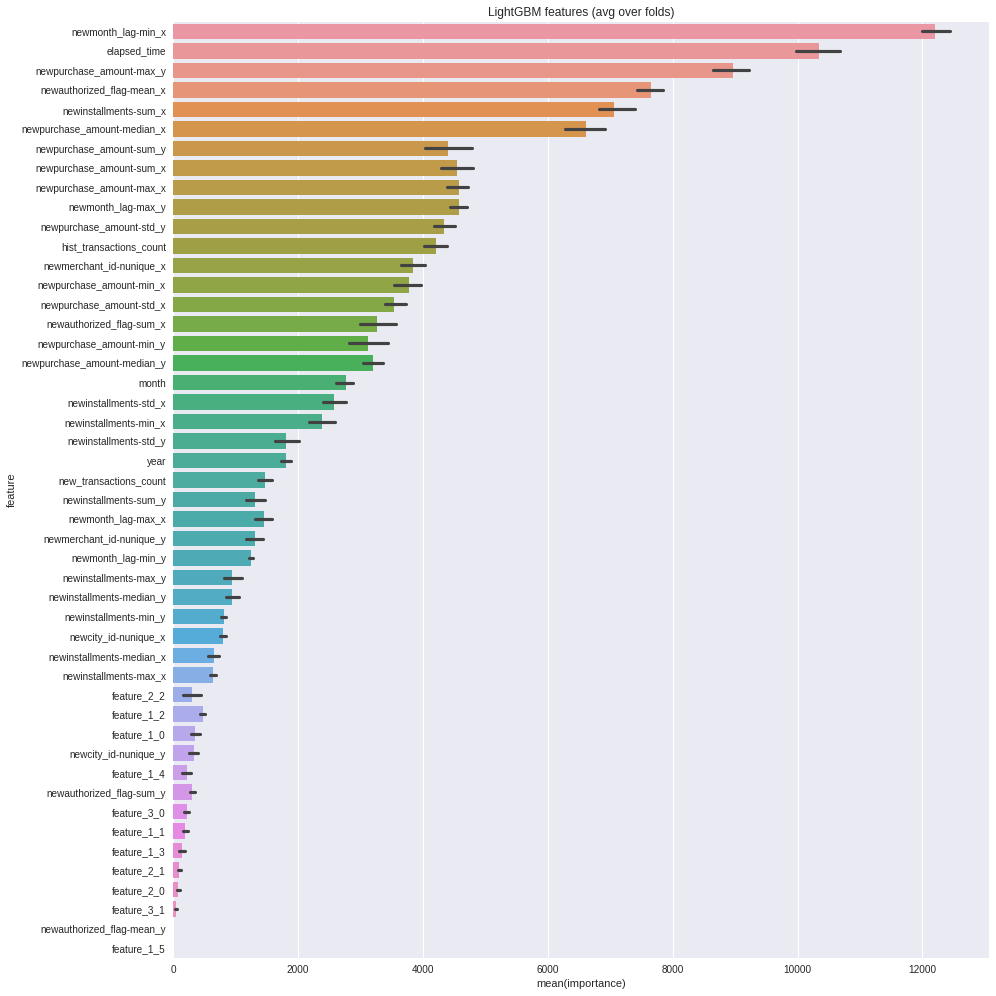

In [54]:
cols = (feature_importance_df_lgb[['feature', 'importance']]
        .groupby('feature')
        .mean()
        .sort_values(by='importance', ascending=False)[:1000].index)

best_features = feature_importance_df_lgb.loc[
    feature_importance_df_lgb.feature.isin(cols)]

plt.figure(figsize=(14, 14))

sns.barplot(x='importance', 
            y='feature', 
            data=best_features.sort_values(
                by='importance', ascending=False))

plt.title('LightGBM features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [56]:
!unzip '/content/sample_submission.csv.zip'

Archive:  /content/sample_submission.csv.zip
  inflating: sample_submission.csv   


In [0]:
# submission
sub_df = pd.read_csv('/content/sample_submission.csv')
sub_df['target'] = 0.5*predictions_lgb + 0.5*predictions_xgb

sub_df.to_csv('submission.csv', index=False)